# Round about simplification
The idea is to be able to select the round abouts using CircularCompactness
and then do create a center point (multiple ways possible) to extend the incoming lines to the round abouts

In [1]:
import osmnx as ox
import folium

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import polygonize, polygonize_full, linemerge
from shapely import geometry
import momepy as mm

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:>

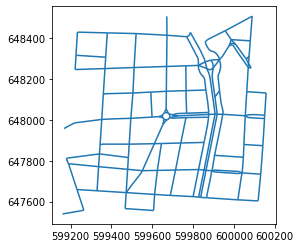

In [3]:
point = 40.432996, -3.691383
dist = 500
G = ox.graph_from_point(point, dist=dist, network_type='drive', simplify = True)
G_projected = ox.project_graph(G)
edges = ox.graph_to_gdfs(ox.get_undirected(G_projected), #prevents some (semi)duplicate geoms
                         nodes=False, edges=True,
                         node_geometry=False, fill_edge_geometry=True)
edges.to_crs(2062, inplace= True)
edges.plot()

<AxesSubplot:>

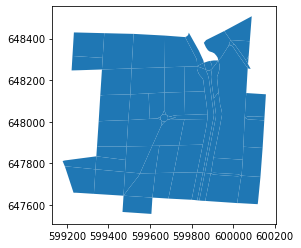

In [8]:
#polygonizing
results, cuts, dangles, invalids = polygonize_full(edges.geometry)

#outputs into GDF for plotting/exploring
res = gpd.GeoDataFrame(data= ['resuls' for d in results.geoms], columns= ['h'],
                                  geometry = [g for g in results.geoms], crs=edges.crs)
cut = gpd.GeoDataFrame(data= ['cuts' for d in cuts.geoms], columns= ['h'],
                                  geometry = [g for g in cuts.geoms], crs=edges.crs)
inv = gpd.GeoDataFrame(data= ['invalid' for d in invalids.geoms], columns= ['h'],
                                  geometry = [g for g in invalids.geoms], crs=edges.crs)
dan = gpd.GeoDataFrame(data= ['dangle' for d in dangles.geoms], columns= ['h'],
                                  geometry = [g for g in dangles.geoms], crs=edges.crs)
res.plot()

In [ ]:
m = res.explore(color = 'grey', name='polygons')

cut.explore(m=m, color= 'red', name = 'cuts')
#inv.explore(m=m, color = 'green', name= 'invalids')
dan.explore(m=m , color = 'black', name='dangles')

folium.LayerControl().add_to(m)  # layer control
m

In [ ]:
# calculate parameters
res["area"] = res.geometry.area
res["circom"] = mm.CircularCompactness(res, "area").series

#select the round abouts based on compactness
comp_threshold = 0.7

rab = res[res.circom > comp_threshold]
rab.plot()

In [ ]:
#selecting the adjacent areas that are of smaller than itself
adj = gpd.sjoin(res, rab, predicate = 'intersects')
adj = adj[adj.area_right >= adj.area_left]
adj = adj[['geometry', 'index_right']]
adj.plot()

Possible ways to understand the center point : 
- centroid, 
- mean point,
- center of bounding circle.

In [ ]:
rab_plus = rabs_center_points(adj)
rab_plus.head()

In [ ]:
rab_plus['exterior'] = rab_plus.geometry.exterior

#select the lines that are incoming but not contained in the round about (ie. 'touches' - 'covered_by')
incoming = edges.sjoin(rab_plus , predicate = 'touches')
incoming_filter = edges.sjoin(rab_plus.set_geometry('exterior') , predicate = 'covered_by').index

incoming.drop(incoming_filter, axis=0, inplace=True)
incoming.plot()

In [ ]:
#figuring out which end of incoming edges needs to be connected to the center_pt
incoming['first_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[0]))
incoming['dist_first_pt'] = incoming.center_pt.distance(incoming.first_pt)
incoming['last_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[-1]))
incoming['dist_last_pt'] = incoming.center_pt.distance(incoming.last_pt)
lines = []
for i, row in incoming.iterrows() :
    if row.dist_first_pt < row.dist_last_pt :
        lines.append(geometry.LineString([row.first_pt, row.center_pt]))
    else :
        lines.append(geometry.LineString([row.last_pt, row.center_pt]))
incoming['line'] = gpd.GeoSeries(lines, index=incoming.index ,crs= edges.crs)

incoming.set_geometry('line').plot()

In [ ]:
incoming['line_wkt'] = incoming.line.apply(lambda x : x.wkt)
count_s = incoming.groupby(['line_wkt'])['line_wkt'].count()
count_s

In [ ]:
incoming['line_wkt'] = incoming.line.apply(lambda x : x.wkt)
count_s = incoming.groupby(['line_wkt'])['line_wkt'].count()
filter_count_one  = pd.DataFrame(count_s[count_s == 1])
filter_count_many  = pd.DataFrame(count_s[count_s > 1])

incoming_ones = pd.merge(incoming, filter_count_one, left_on='line_wkt', right_index=True, how= 'inner')
incoming_many = pd.merge(incoming, filter_count_many, left_on='line_wkt', right_index=True, how= 'inner')
incoming_many.plot()

In [ ]:
# identifying out the multiple connections, 
# which one needs to be extended and retain attributes
coins_filter_result = []
# So, for each new connection, evaluate COINS and selecet the group from which the new line belongs
for g, x in incoming_many.groupby('line_wkt'):
    gs = gpd.GeoSeries( pd.concat([x.geometry, x.line]), crs= incoming_many.crs )
    gdf = gpd.GeoDataFrame(geometry = gs)
    gdf.drop_duplicates(inplace=True)
    
    coins = mm.COINS(gdf, angle_threshold=0)
    stroke_gdf = coins.stroke_gdf()
    
    orig_geom_join = stroke_gdf.sjoin(gpd.GeoDataFrame(geometry = x.line), predicate= 'covers' )
    orig_geom = gpd.GeoSeries([orig_geom_join.geometry.iloc[0]], crs= incoming_many.crs)
    gs2 = gpd.GeoDataFrame(geometry = orig_geom)
    
    gs1 = gpd.GeoSeries(x.geometry, crs= incoming_many.crs )
    gs1 = gpd.GeoDataFrame(geometry = gs1)
    
    #select the the line that's covered by the joined line returned by COINS
    result_dx = gs1.sjoin(gs2 , predicate = 'covered_by').index
    coins_filter_result.extend(result_dx)

incoming_many_reduced = incoming_many.loc[coins_filter_result]

incoming_alll = gpd.GeoDataFrame(pd.concat([incoming_ones, incoming_many_reduced]), crs = edges.crs)
incoming_alll.plot()

In [ ]:
# updating the original geometry 
## this is causing a warning too for Shapely 2.0 --> Convert the '.coords' to a numpy array
incoming['geometry'] = incoming.apply(lambda row: linemerge([row.geometry, row.line]), axis =1)
incoming.plot()

In [ ]:
m = rab_plus.explore(color = 'grey', name='polygons')

rab_plus.set_geometry('mean_pts').explore(m=m, color= 'red', name = 'mean_pts')
rab_plus.set_geometry('centroid').explore(m=m, color= 'blue', name = 'centroid')

joined.set_geometry('line').explore(m=m , color = 'black', name = 'new_line')

edges.explore(m=m)
folium.LayerControl().add_to(m)  # layer control
m

In [ ]:
#merge newline with upcoming edges

#1 selecte lines that touch further pts
joined.set_geometry('pts', inplace=True)
modified = gpd.sjoin(edges,joined[['pts','line','dist']], predicate = 'touches')
modified.drop(columns = ['index_right'], inplace=True)
modified.plot()

In [ ]:
# This feels a bit combersome ... Ideally there would be a DISJOINT predicate
filter_gdf = gpd.sjoin(modified, rab_plus.reset_index(drop=True), predicate = 'covered_by', how = 'inner').index
modified.drop(filter_gdf, axis=0, inplace=True) 
modified.tail(2)

In [ ]:
# select only those links those which have 1 line to connect to! - 
modified['line_wkt'] = modified.line.apply(lambda x : x.wkt)
count_s = modified.groupby(['line_wkt'])['line_wkt'].count()
filter_count  = pd.DataFrame(count_s[count_s == 1])

modified = pd.merge(modified, filter_count, left_on='line_wkt', right_index=True, how= 'inner')
modified.plot()

#lines with more than one connection (count_s > 1) need futher investigation

In [ ]:
#updating the original geometry 
# this is causing a warning too for Shapely 2.0 --> Convert the '.coords' to a numpy array
modified['geometry'] = modified.apply(lambda row: linemerge([row.geometry, row.line]), axis =1)
modified.plot()

# --- TESTING FUNCTIONS ----

In [10]:
def selecting_rabs_from_poly(gdf, circom_threshold = 0.7):
    """
    From a GeoDataFrame of polygons, returns two GDF of polygons that are 
    above the CircularCompaactness threshold as well as those adjacent ones samller in area
    
    Return
    ________
    tuple of GeoDataFrames : (round abouts and adjacent polys, adjacent only)
    """
    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(res, "area").series
    
    #selecting round about polygons based on compactness
    rab = gdf[gdf.circom > circom_threshold]
    
    #selecting the adjacent areas that are of smaller than itself
    rab = gpd.sjoin(gdf, rab, predicate = 'intersects')
    rab = rab[rab.area_right >= rab.area_left]
    rab = rab[['geometry', 'index_right']]
    
    return rab

def rabs_center_points(gdf, center_type = 'mean'):
    """
    From a selection of round abouts and adjacent polygons, 
    returns an aggregated GeoDataFrame per round about with extra column with center_type. 
    
    center_type, str
        - mean: (default) mean point of node geometries that make up polygons
        - centroid : of the combined polygons
        - minimum_bounding_circle : TBD
    
    Return
    ________
    GeoDataFrame
    """
    #dissolving into a single geometry per round about
    rab_plus = gdf.dissolve(by = 'index_right')
    
    if center_type == 'mean':
        # mean geometry
        ls_xy = [g.exterior.coords.xy for g in rab_plus.geometry] #extracting the points
        mean_pts = [geometry.Point(np.mean(xy[0]),np.mean(xy[1])) for xy in ls_xy]
        rab_plus['center_pt'] = gpd.GeoSeries( data = mean_pts, 
                                              index = rab_plus.index, 
                                              crs = edges.crs)
    
    elif center_type == 'centroid' :
        #geometry centroid
        rab_plus['center_pt'] = rab_plus.geometry.centroid
    
    # centerpoint of minimum_bounding_circle
    # minimun_bounding_circle() not available in Shapely 1.8.2 but only in 'latest'
    # --> https://shapely.readthedocs.io/en/latest/constructive.html
    # current environment has 1.8.2 see 
    
    return rab_plus

In [11]:
def coins_filtering_many_incoming(incoming_many):
    # From multiple incoming lines 
    # figuring out which one needs to be extended and retain attributes
    coins_filter_result = []
    # For each new connection, evaluate COINS and selecet the group from which the new line belongs
    for g, x in incoming_many.groupby('line_wkt'):
        gs = gpd.GeoSeries( pd.concat([x.geometry, x.line]), crs= incoming_many.crs )
        gdf = gpd.GeoDataFrame(geometry = gs)
        gdf.drop_duplicates(inplace=True)

        coins = mm.COINS(gdf, angle_threshold=0)
        stroke_gdf = coins.stroke_gdf()

        orig_geom_join = stroke_gdf.sjoin(gpd.GeoDataFrame(geometry = x.line), predicate= 'covers' )
        orig_geom = gpd.GeoSeries([orig_geom_join.geometry.iloc[0]], crs= incoming_many.crs)
        gs2 = gpd.GeoDataFrame(geometry = orig_geom)

        gs1 = gpd.GeoSeries(x.geometry, crs= incoming_many.crs )
        gs1 = gpd.GeoDataFrame(geometry = gs1)

        #select the the line that's covered by the joined line returned by COINS
        result_dx = gs1.sjoin(gs2 , predicate = 'covered_by').index
        coins_filter_result.extend(result_dx)
    
    incoming_many_reduced = incoming_many.loc[coins_filter_result]
    return incoming_many_reduced


In [12]:
def ext_lines_to_center(edges, rab_plus):
    # selecting only the lines that are touching but not covered_by
    # Feels a bit combersome ... Ideally there would be a DISJOINT predicate
    incoming = edges.sjoin(rab_plus , predicate = 'touches')
    incoming.rename(columns ={'index_right':'index_rab_plus'}, inplace = True )
    idx_drop =  incoming.sjoin(rab_plus, predicate = 'covered_by').index
    incoming.drop(idx_drop, axis=0, inplace =True)

    #figuring out which ends of incoming edges needs to be connected to the center_pt
    incoming['first_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[0]))
    incoming['dist_fisrt_pt'] = incoming.center_pt.distance(incoming.first_pt)
    incoming['last_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[-1]))
    incoming['dist_last_pt'] = incoming.center_pt.distance(incoming.last_pt)
    lines = []
    for i, row in incoming.iterrows() :
        if row.dist_fisrt_pt < row.dist_last_pt :
            lines.append(geometry.LineString([row.first_pt, row.center_pt]))
        else :
            lines.append( geometry.LineString([row.last_pt, row.center_pt]))
    incoming['line'] = gpd.GeoSeries(lines, index=incoming.index ,crs= edges.crs)

    incoming['line_wkt'] = incoming.line.apply(lambda x : x.wkt)
    count_s = incoming.groupby(['line_wkt'])['line_wkt'].count()
    
    #separating the incoming roads that come on their own to those that come in groups
    filter_count_one  = pd.DataFrame(count_s[count_s == 1])
    filter_count_many  = pd.DataFrame(count_s[count_s > 1])
    incoming_ones = pd.merge(incoming, filter_count_one, left_on='line_wkt', right_index=True, how= 'inner')
    incoming_many = pd.merge(incoming, filter_count_many, left_on='line_wkt', right_index=True, how= 'inner')

    incoming_many_reduced = coins_filtering_many_incoming(incoming_many)
    incoming_all = gpd.GeoDataFrame(pd.concat([ incoming_ones, incoming_many_reduced]), crs = edges.crs)

    # updating the original geometry 
    ## this is causing a warning too for Shapely 2.0 --> Convert the '.coords' to a numpy array
    incoming_all['geometry'] = incoming_all.apply(lambda row: linemerge([row.geometry, row.line]), axis =1)

    # deleting the original round about edges
    idx_out = edges.sjoin(rab_plus, predicate= 'covered_by', how='inner').index
    new_edges = edges.drop(idx_out, axis=0)

    #replacing the modified edges in the output
    #ideally uising MAPPING but I didn't manage to make it work with multiindex!!
    
    #ratianing the same gdf shape that the original
    incoming_all = incoming_all[edges.columns]
    new_edges = pd.concat([new_edges, incoming_all])
    
    return new_edges

In [13]:
def round_about_simpl(edges, polys, circom_threshold = 0.7, center_type = 'mean'):
    
    rab = selecting_rabs_from_poly(res, circom_threshold = circom_threshold)
    rab_plus = rabs_center_points(rab, center_type = center_type)
    output = ext_lines_to_center(edges, rab_plus)
    
    return output

In [14]:
new_edges = round_about_simpl(edges, res)

m = new_edges.explore(name='new edges', color ='red')
edges.explore(m=m, name = 'edges', color = 'black')

folium.LayerControl().add_to(m)  # layer control
m

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

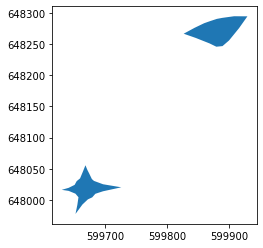

In [34]:
###
rab = selecting_rabs_from_poly(res, circom_threshold = 0.7)
rab_plus = rabs_center_points(rab, center_type = 'mean')
rab_plus.plot()

<AxesSubplot:>

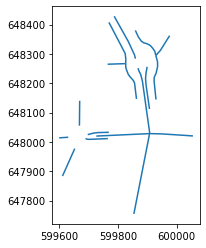

In [64]:
#select the lines that are not the furthest point but also somehow touching the round about
incoming = edges.sjoin(rab_plus , predicate = 'touches')
incoming.rename(columns ={'index_right':'index_rab_plus'}, inplace = True )
idx_drop =  incoming.sjoin(rab_plus, predicate = 'covered_by').index
incoming.drop(idx_drop, axis=0, inplace =True)

#figuring out which ends of incoming edges needs to be connected to the center_pt
incoming['first_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[0]))
incoming['dist_fisrt_pt'] = incoming.center_pt.distance(incoming.first_pt)
incoming['last_pt'] = incoming.geometry.apply(lambda x : geometry.Point( x.coords[-1]))
incoming['dist_last_pt'] = incoming.center_pt.distance(incoming.last_pt)
lines = []
for i, row in incoming.iterrows() :
    if row.dist_fisrt_pt < row.dist_last_pt :
        lines.append(geometry.LineString([row.first_pt, row.center_pt]))
    else :
        lines.append( geometry.LineString([row.last_pt, row.center_pt]))
incoming['line'] = gpd.GeoSeries(lines, index=incoming.index ,crs= edges.crs)
incoming.plot()

In [51]:
rab_plus

,geometry,center_pt
index_right,,
34,"POLYGON ((599845.629 648260.293, 599826.347 64...",POINT (599876.282 648272.378)
54,"POLYGON ((599663.505 647992.354, 599652.384 64...",POINT (599668.225 648017.759)


<AxesSubplot:>

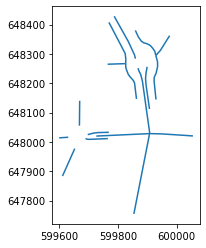

In [59]:
incoming.rename(columns ={'index_right':'index_rab_plus'}, inplace = True )
idx_drop =  incoming.sjoin(rab_plus, predicate = 'covered_by').index
incoming.drop(idx_drop, axis=0, inplace =True)
incoming.plot()

<AxesSubplot:>

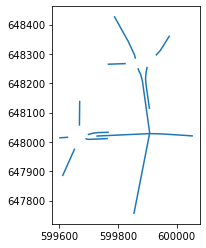

In [62]:
incoming['line_wkt'] = incoming.line.apply(lambda x : x.wkt)
count_s = incoming.groupby(['line_wkt'])['line_wkt'].count()

#separating the incoming roads that come on their own to those that come in groups
filter_count_one  = pd.DataFrame(count_s[count_s == 1])
filter_count_many  = pd.DataFrame(count_s[count_s > 1])
incoming_ones = pd.merge(incoming, filter_count_one, left_on='line_wkt', right_index=True, how= 'inner')
incoming_many = pd.merge(incoming, filter_count_many, left_on='line_wkt', right_index=True, how= 'inner')

incoming_many_reduced = coins_filtering_many_incoming(incoming_many)
incoming_all = gpd.GeoDataFrame(pd.concat([ incoming_ones, incoming_many_reduced]), crs = edges.crs)
incoming_all.plot()

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

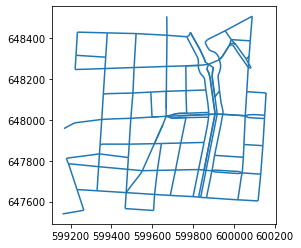

In [63]:
# updating the original geometry 
## this is causing a warning too for Shapely 2.0 --> Convert the '.coords' to a numpy array
incoming_all['geometry'] = incoming_all.apply(lambda row: linemerge([row.geometry, row.line]), axis =1)

# deleting the original round about edges
idx_out = edges.sjoin(rab_plus, predicate= 'covered_by', how='inner').index
new_edges = edges.drop(idx_out, axis=0)

#replacing the modified edges in the output
#ideally uising MAPPING but I didn't manage to make it work with multiindex!!

#ratianing the same gdf shape that the original
incoming_all = incoming_all[edges.columns]
new_edges = pd.concat([new_edges, incoming_all])
new_edges.plot()

# testing for centerlline of actual circle i.e. not all roundabout

<AxesSubplot:>

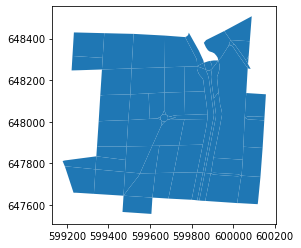

In [5]:
polys = polygonize(edges.geometry)
polys = gpd.GeoDataFrame(geometry = [g for g in polys], crs=edges.crs)
polys.plot()

In [28]:
def selecting_rabs_from_poly(gdf, circom_threshold = 0.7):
    """
    From a GeoDataFrame of polygons, returns two GDF of polygons that are 
    above the CircularCompaactness threshold as well as those adjacent ones samller in area
    
    Return
    ________
    tuple of GeoDataFrames : (round abouts and adjacent polys, adjacent only)
    """
    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series
    
    #selecting round about polygons based on compactness
    rab = gdf[gdf.circom > circom_threshold]
    
    #selecting the adjacent areas that are of smaller than itself
    rab = gpd.sjoin(gdf, rab, predicate = 'intersects')
    rab = rab[rab.area_right >= rab.area_left]
    rab = rab[['geometry', 'index_right']]
    
    return rab

<AxesSubplot:>

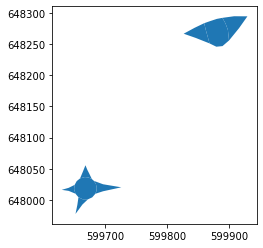

In [29]:
rab = selecting_rabs_from_poly(polys)
rab.plot()

In [30]:
rab.head()

,geometry,index_right
30,"POLYGON ((599867.868 648251.474, 599845.629 64...",34
34,"POLYGON ((599899.261 648256.155, 599888.743 64...",34
38,"POLYGON ((599888.650 648292.534, 599907.474 64...",34
26,"POLYGON ((599696.680 648024.917, 599725.972 64...",54
53,"POLYGON ((599659.727 648034.379, 599664.364 64...",54


In [35]:
rab[rab.index == rab.index_right].geometry.centroid

34    POINT (599880.318 648269.175)
54    POINT (599668.368 648018.418)
dtype: geometry

In [34]:
def rabs_center_points(gdf, center_type = 'centroid'):
 #dissolving into a single geometry per round about
    rab_plus = gdf.dissolve(by = 'index_right')
    
    if center_type == 'centroid' :
        #geometry centroid of the actual circle
        rab_plus['center_pt'] = rab[rab.index == rab.index_right].geometry.centroid
    
    elif center_type == 'mean':
        # mean geometry
        ls_xy = [g.exterior.coords.xy for g in rab_plus.geometry] #extracting the points
        mean_pts = [geometry.Point(np.mean(xy[0]),np.mean(xy[1])) for xy in ls_xy]
        rab_plus['center_pt'] = gpd.GeoSeries( data = mean_pts, 
                                              index = rab_plus.index, 
                                              crs = edges.crs)
    
    # centerpoint of minimum_bounding_circle
    # minimun_bounding_circle() not available in Shapely 1.8.2 but only in 'latest'
    # --> https://shapely.readthedocs.io/en/latest/constructive.html
    # current environment has 1.8.2
    
    return rab_plus

<AxesSubplot:>

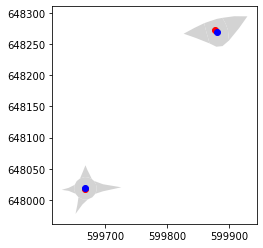

In [36]:
rab_centroid = rabs_center_points(rab)
rab_mean  = rabs_center_points(rab, center_type= 'mean')

ax = rab.plot(color = 'lightgrey')
rab_mean.center_pt.plot(ax=ax , color = 'red')
rab_centroid.center_pt.plot(ax=ax , color = 'blue')